In [80]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

In [81]:
def recalc_val(save_path):
    net_config_path = save_path + 'net_configs.p'
    state_dict_path = save_path + 'model.pt'
    datasets = [ 
        inputs.Sim1DWalk(num_steps=500, left_right_stay_prob=[5,1,1], num_states=64),
        inputs.Sim2DWalk(num_steps=500, num_states=64),
        inputs.Sim2DLevyFlight(num_steps=500, walls=7)
        ]
    with open(net_config_path, 'rb') as f:
        net_configs = pickle.load(f)
    net = STDP_SR(
        num_states=64, gamma=net_configs['gamma'],
        ca3_kwargs=net_configs['ca3_kwargs']
        )
    net.load_state_dict(torch.load(state_dict_path))
    net.ca3.set_differentiability(False)
    
    criterion = nn.MSELoss(reduction='none')
    errs = []
    with torch.no_grad():
        for dset in datasets:
            dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
            dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
            _, outputs = net(dg_inputs, dg_modes, reset=True)
            est_T = net.ca3.get_T().detach().numpy()
            real_T = net.ca3.get_real_T()
            err = np.mean(np.abs(est_T - real_T))
            errs.append(err)
    return np.mean(err)

In [110]:
param_regex = 'pos(.*)_neg(.*)'
gridsearch_dir = "../trained_models/01_tau_gridsearch/"
tau_neg_axes = []
tau_pos_axes = []
vals = []
A_poses = []
A_negs = []
results = {
    'tau_neg_axes': tau_neg_axes,
    'tau_pos_axes': tau_pos_axes,
    'vals': vals,
    'A_poses': A_poses,
    'A_negs': A_negs
}
for d in os.listdir(gridsearch_dir):
    param_match = re.search(param_regex, d)
    if param_match is None: continue
    tau_pos_axes.append(float(param_match.group(1)))
    tau_neg_axes.append(float(param_match.group(2)))

#     try:
#         val = recalc_val(gridsearch_dir + d + '/')
#     except:
#         val = np.nan
        
    val = np.inf
    A_pos = np.nan
    A_neg = np.nan
    for file in os.listdir(gridsearch_dir + d):
        if 'tfevents' not in file: continue
        tfevents_file = gridsearch_dir + d + '/' + file
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        _val = event_acc.Scalars('loss_train')[-1].value
        if _val < val:
            val = _val
            model_file = gridsearch_dir + d + '/' + 'model.pt'
            state_dict = torch.load(model_file)
            A_pos = abs(state_dict['ca3.A_pos'])
            A_neg = abs(state_dict['ca3.A_neg'])
    vals.append(val)
    A_poses.append(A_pos)
    A_negs.append(A_neg)

In [111]:
tau_neg_axes = np.array(results['tau_neg_axes'])
tau_pos_axes = np.array(results['tau_pos_axes'])
tau_neg_unique = np.sort(np.unique(xs))
tau_pos_unique = np.sort(np.unique(ys))

# Plot errors where scaling factors is sufficient

In [112]:
Aneg_coeff_mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, A_neg in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['A_negs']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    Aneg_coeff_mat[x_idx][y_idx] = A_neg*10*np.exp(-1/abs(tau_neg_ax))

In [113]:
Apos_coeff_mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, A_pos in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['A_poses']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    Apos_coeff_mat[x_idx][y_idx] = A_pos*10*np.exp(-1/abs(tau_neg_ax))

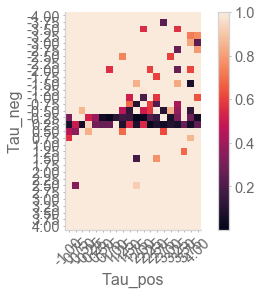

In [119]:
plt.figure()
plt.imshow(Apos_coeff_mat, vmax=1)
plt.yticks(np.arange(xs.size), [f'{x:.2f}' for x in xs])
plt.xticks(
    np.arange(ys.size), [f'{y:.2f}' for y in ys],
    rotation=45
    )
plt.xlabel('Tau_pos')
plt.ylabel('Tau_neg')
plt.colorbar()
plt.show()

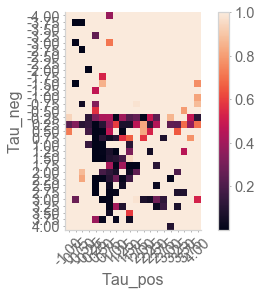

In [118]:
plt.figure()
plt.imshow(Aneg_coeff_mat, vmax=1)
plt.yticks(np.arange(xs.size), [f'{x:.2f}' for x in xs])
plt.xticks(
    np.arange(ys.size), [f'{y:.2f}' for y in ys],
    rotation=45
    )
plt.xlabel('Tau_pos')
plt.ylabel('Tau_neg')
plt.colorbar()
plt.show()

In [116]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

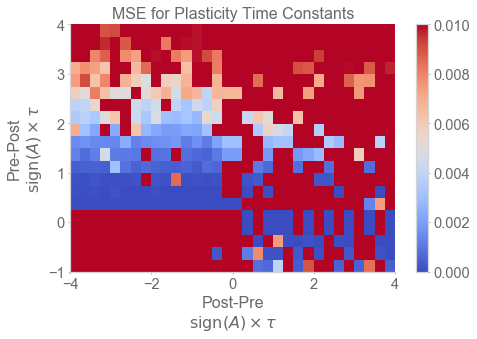

In [117]:
from scipy.ndimage.filters import gaussian_filter
coeff_threshold = 0.1

# Collect values
mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, val in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['vals']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    mat[x_idx][y_idx] = val

# "Zero"-out entries where coefficient approaches zero
mat[Aneg_coeff_mat<coeff_threshold] = 0.05
mat[Apos_coeff_mat<coeff_threshold] = 0.05

#mat = gaussian_filter(mat, 0.5)

x_list = np.sort(np.unique(xs))
y_list = np.sort(np.unique(ys))
x, y = np.meshgrid(x_list, y_list)
fig, ax = plt.subplots(figsize=(7,5))
im = ax.pcolormesh(
    x, y, mat.T, cmap="coolwarm", vmax=0.01
    )
fig.colorbar(im, ax=ax)

#plt.yticks([0, 2, 4])
plt.xlabel('Post-Pre\n$\mathrm{sign}(A)\\times \\tau$')
plt.ylabel('Pre-Post\n$\mathrm{sign}(A)\\times \\tau$')
plt.title("MSE for Plasticity Time Constants")
plt.tight_layout()
plt.savefig("tau_grid_mse_zeroed.png", dpi=300)
plt.show()